# 베이지안 갱신

In [1]:
import numpy as np
from scipy.stats import beta, binom
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns

In [2]:
x = np.array([0,0,1]) # 아웃, 아웃, 안타

In [3]:
def bayes_update(x,a,b):
    # (1) 그림의 틀 짜기, (1 x n)의 그림을 한 번에 표시하고 x축/y축을 공유 
    n = len(x)+1
    fig, axs = plt.subplots(1, n, sharex=True, sharey=True) 
    fig.set_figheight(4) # 그림의 높이
    fig.set_figwidth(4*len(x)) # 그림의 너비
        
    # (2) n번의 타석 중 x번 안타인 경우, 타율의 추청값 = x/n
    mle = sum(x)/len(x)
    
    # (3) 베이지안 갱신을 시각적으로 보여주는 그림 그리기  
    pt = np.linspace(0,1,100)
    
    for i in range(n):      
        if i==0:
            al = a
            be = b
        else:
            al = a+sum(x[:i])
            be = b+i-sum(x[:i])
        
        y = beta.pdf(pt,al,be)
        axs[i].plot(pt, y, 'r-') # 빨간색 실선
        axs[i].axvline(mle,linestyle='--',color='b') # 파란색 수직 파선
        axs[i].set_title('Beta($\\alpha$={}, $\\beta$={})'.format(al, be))
        axs[i].text(mle+0.03,0,str(round(mle,2)))        
        
    plt.show()

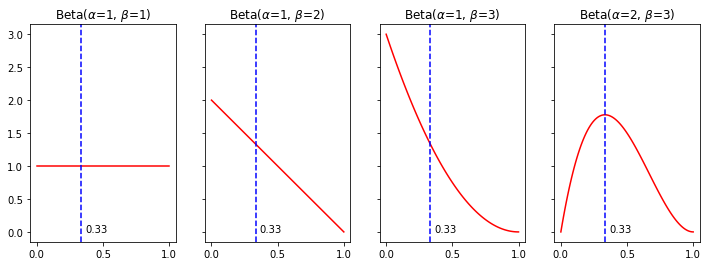

In [4]:
bayes_update(x,1,1)

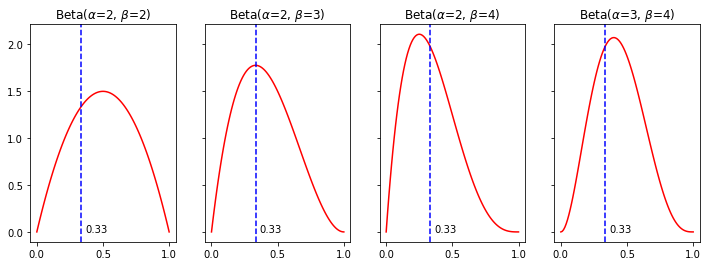

In [5]:
bayes_update(x,2,2)

In [6]:
n = 50
p = 0.3
x = binom.rvs(1, p, size=n)
x

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0])

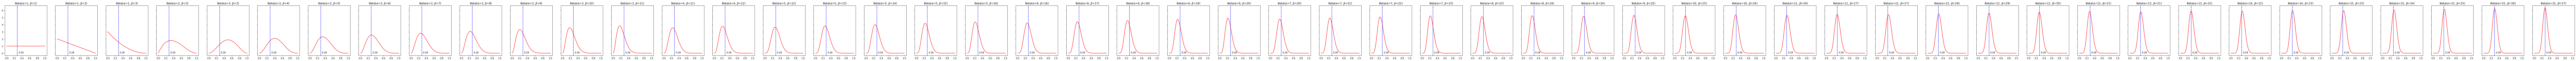

In [7]:
bayes_update(x,1,1)

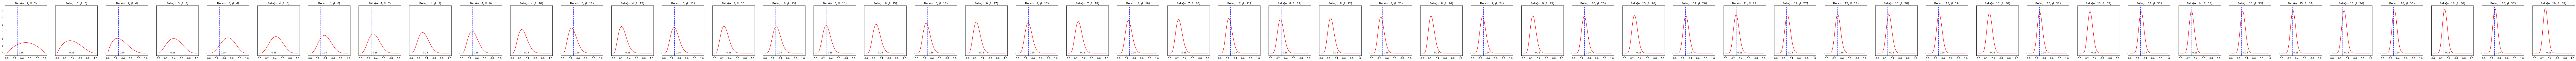

In [8]:
bayes_update(x,2,2)

# 베이지안 A/B 테스트

In [10]:
n_A = 1312; x_A = 40
n_B = 1067; x_B = 38
a = 1
b = 1

In [12]:
def beta_post(n,x,a,b,type='samp',nsamp=10000):
    if type=='mean': # 베타 사후 분포의 평균 계산
        mean = (x+a)/(n+a+b)
        return mean
    elif type=='median': # 베타 사후 분포의 중앙값 계산
        median = beta.ppf(0.5,x+a,n-x+b)
        return median
    elif type=='mode': # 베타 사후 분포의 최빈값 계산
        mode = (x+a-1)/(n+a+b-2)
        return mode
    elif type=='samp': # 베타 사후 분포의 시뮬레이션
        rsamp = beta.rvs(x+a,n-x+b,size=nsamp)
        return rsamp

In [13]:
th_A = beta_post(n_A,x_A,a,b,'mean')
th_B = beta_post(n_B,x_B,a,b,'mean')
print('A안의 평균 전환율 = {}%'.format(np.round(th_A*100,2))) # format 메서드 사용
print('B안의 평균 전환율 = {}%'.format(np.round(th_B*100,2))) # format 메서드 사용

A안의 평균 전환율 = 3.12%
B안의 평균 전환율 = 3.65%


In [14]:
th_A = beta_post(n_A,x_A,a,b,'median')
th_B = beta_post(n_B,x_B,a,b,'median')
print('A안의 중앙 전환율 = {}%'.format(np.round(th_A*100,2))) # format 메서드 사용
print('B안의 중앙 전환율 = {}%'.format(np.round(th_B*100,2))) # format 메서드 사용
th_A = beta_post(n_A,x_A,a,b,'mode')
th_B = beta_post(n_B,x_B,a,b,'mode')
print('A안의 최빈 전환율 = {}%'.format(np.round(th_A*100,2))) # format 메서드 사용
print('B안의 최빈 전환율 = {}%'.format(np.round(th_B*100,2))) # format 메서드 사용

A안의 중앙 전환율 = 3.1%
B안의 중앙 전환율 = 3.62%
A안의 최빈 전환율 = 3.05%
B안의 최빈 전환율 = 3.56%


In [16]:
th_A_samp = beta_post(n_A,x_A,a,b)
th_B_samp = beta_post(n_B,x_B,a,b) 
th_diff = th_B_samp-th_A_samp
print('기존안 대비 전환율 평균 개선 정도 = {}%'.format(np.round(np.mean(th_diff/th_A_samp)*100,2)))

기존안 대비 전환율 평균 개선 정도 = 19.88%


In [17]:
print('기존안보다 전환율이 개선될 확률 = {}%'.format(np.round(np.mean(th_diff>0)*100,2)))

기존안보다 전환율이 개선될 확률 = 76.22%


In [18]:
cvr = pd.DataFrame({'A':th_A_samp,'B':th_B_samp})

In [19]:
A_mode   = beta_post(n_A,x_A,a,b,'mode')
A_mean   = beta_post(n_A,x_A,a,b,'mean')
A_median = beta_post(n_A,x_A,a,b,'median')

B_mode   = beta_post(n_B,x_B,a,b,'mode')
B_mean   = beta_post(n_B,x_B,a,b,'mean')
B_median = beta_post(n_B,x_B,a,b,'median')

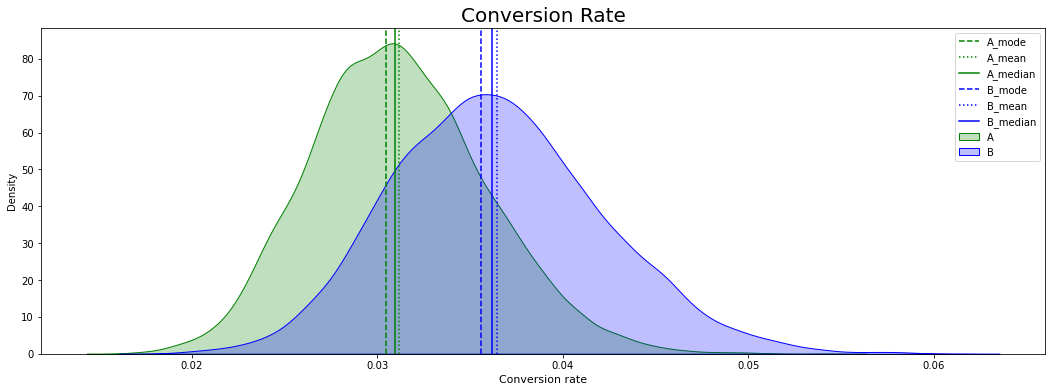

In [20]:
plt.figure(figsize=(18,6))

sns.kdeplot(cvr['A'],color='green',shade='Fill',label='A')
sns.kdeplot(cvr['B'],color='blue',shade='Fill',label='B')
plt.xlabel('Conversion rate', fontsize=11)

plt.axvline(A_mode,ls='--',color='green',label='A_mode')
plt.axvline(A_mean,ls=':',color='green',label='A_mean')
plt.axvline(A_median,color='green',label='A_median')

plt.axvline(B_mode,ls='--',color='blue',label='B_mode')
plt.axvline(B_mean,ls=':',color='blue',label='B_mean')
plt.axvline(B_median,color='blue',label='B_median')

plt.legend()
plt.title('Conversion Rate',size=20)
plt.show()

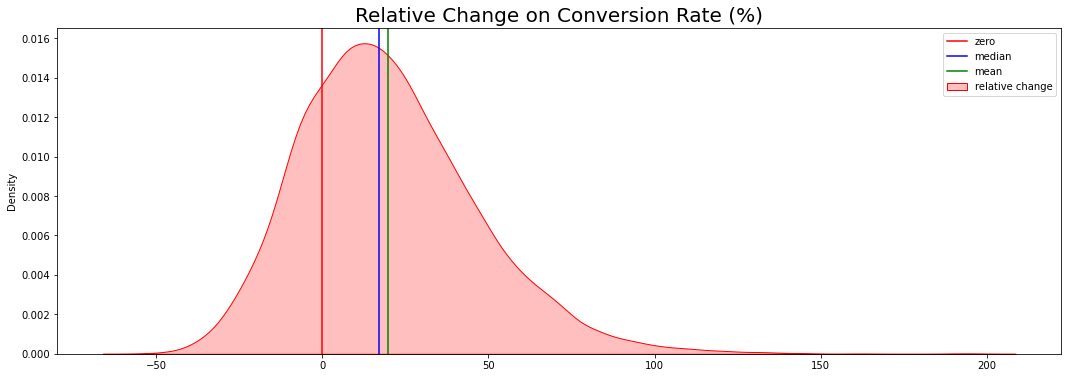

In [21]:
plt.figure(figsize=(18,6))


mean   = np.mean((cvr['B']-cvr['A'])*100/cvr['A'])
median = np.median((cvr['B']-cvr['A'])*100/cvr['A'])

sns.kdeplot((cvr['B']-cvr['A'])*100/cvr['A'],color='red',shade='Fill',label='relative change')

plt.axvline(0,color='red',label='zero')
plt.axvline(median,color='blue',label='median')
plt.axvline(mean,color='green',label='mean')

plt.legend()
plt.title('Relative Change on Conversion Rate (%)',size=20)
plt.show()

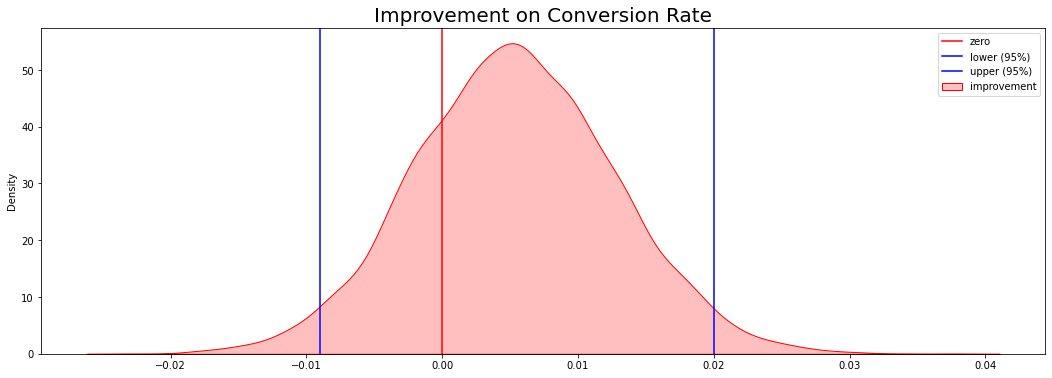

In [22]:
plt.figure(figsize=(18,6))

lower = np.percentile(cvr['B']-cvr['A'],2.5)
upper = np.percentile(cvr['B']-cvr['A'],97.5)

sns.kdeplot(cvr['B']-cvr['A'],color='red',shade='Fill',label='improvement')

plt.axvline(0,color='red',label='zero')
plt.axvline(lower,color='blue',label='lower (95%)')
plt.axvline(upper,color='blue',label='upper (95%)')

plt.legend()
plt.title('Improvement on Conversion Rate',size=20)
plt.show()

예측

In [23]:
n_A = n_B = 10000
x_A_samp = binom.rvs(n_A,th_A_samp)
x_B_samp = binom.rvs(n_B,th_B_samp)

In [24]:
print('1만명당 A안의 평균 전환수 = {}'.format(np.round(np.mean(x_A_samp)))) 
print('1만명당 B안의 평균 전환수 = {}'.format(np.round(np.mean(x_B_samp)))) 

1만명당 A안의 평균 전환수 = 311.0
1만명당 B안의 평균 전환수 = 365.0


In [25]:
lower_A = np.round(np.percentile(x_A_samp,2.5))
upper_A = np.round(np.percentile(x_A_samp,97.5))
lower_B = np.round(np.percentile(x_B_samp,2.5))
upper_B = np.round(np.percentile(x_B_samp,97.5))
print('1만명당 A안의 전환수에 대한 95% 신용구간 = ({},{})'.format(lower_A,upper_A)) 
print('1만명당 B안의 전환수에 대한 95% 신용구간 = ({},{})'.format(lower_B,upper_B))

1만명당 A안의 전환수에 대한 95% 신용구간 = (219.0,419.0)
1만명당 B안의 전환수에 대한 95% 신용구간 = (256.0,490.0)


In [26]:
count_diff = x_B_samp-x_A_samp
print('기존안 대비 전환수 평균 개선 정도 = {}%'.format(np.round(np.mean(count_diff/x_A_samp)*100,2)))

기존안 대비 전환수 평균 개선 정도 = 20.32%


In [27]:
print('기존안보다 전환수가 개선될 확률 = {}%'.format(np.round(np.mean(count_diff>0)*100,2)))

기존안보다 전환수가 개선될 확률 = 75.14%


In [28]:
cv_pred = pd.DataFrame({'A':x_A_samp,'B':x_B_samp})

In [29]:
A_mean   = np.mean(cv_pred['A'])
A_median = np.median(cv_pred['A'])

B_mean   = np.mean(cv_pred['B'])
B_median = np.median(cv_pred['B'])

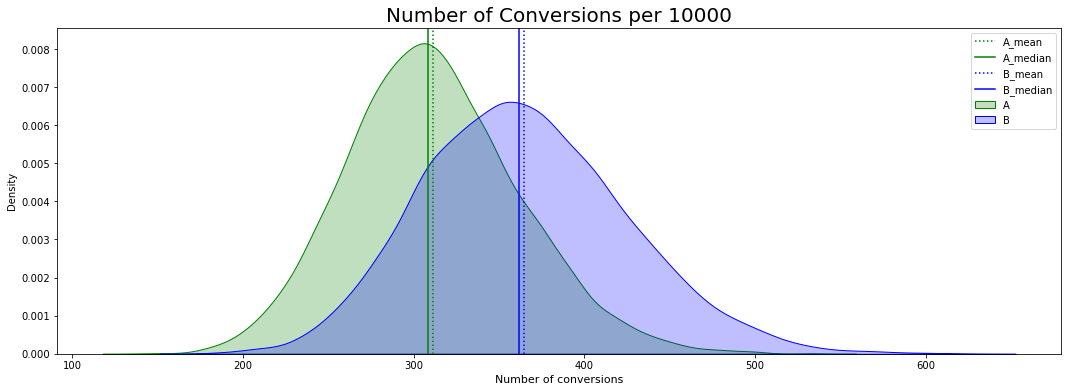

In [30]:
plt.figure(figsize=(18,6))

sns.kdeplot(cv_pred['A'],color='green',shade='Fill',label='A')
sns.kdeplot(cv_pred['B'],color='blue',shade='Fill',label='B')
plt.xlabel('Number of conversions', fontsize=11)

plt.axvline(A_mean,ls=':',color='green',label='A_mean')
plt.axvline(A_median,color='green',label='A_median')

plt.axvline(B_mean,ls=':',color='blue',label='B_mean')
plt.axvline(B_median,color='blue',label='B_median')

plt.legend()
plt.title('Number of Conversions per 10000',size=20)
plt.show()

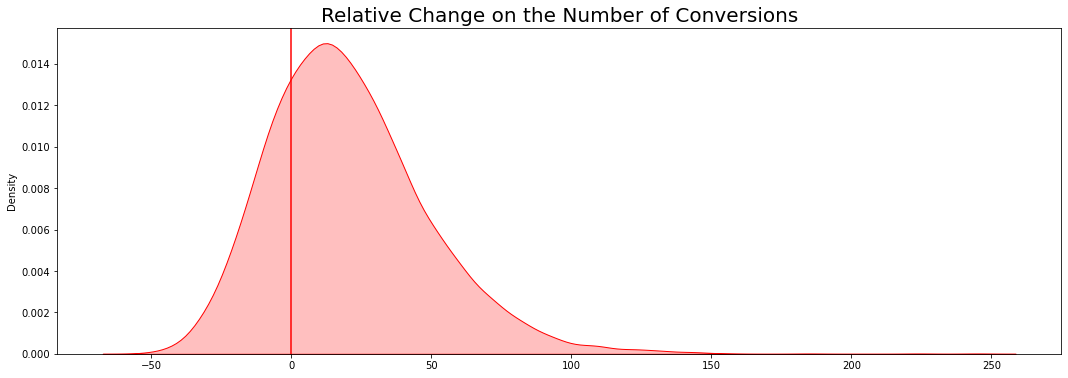

In [31]:
plt.figure(figsize=(18,6))

sns.kdeplot((cv_pred['B']-cv_pred['A'])*100/cv_pred['A'],color='red',shade='Fill',label='relative change')
plt.axvline(0,color='red',label='zero')

plt.title('Relative Change on the Number of Conversions',size=20)
plt.show()

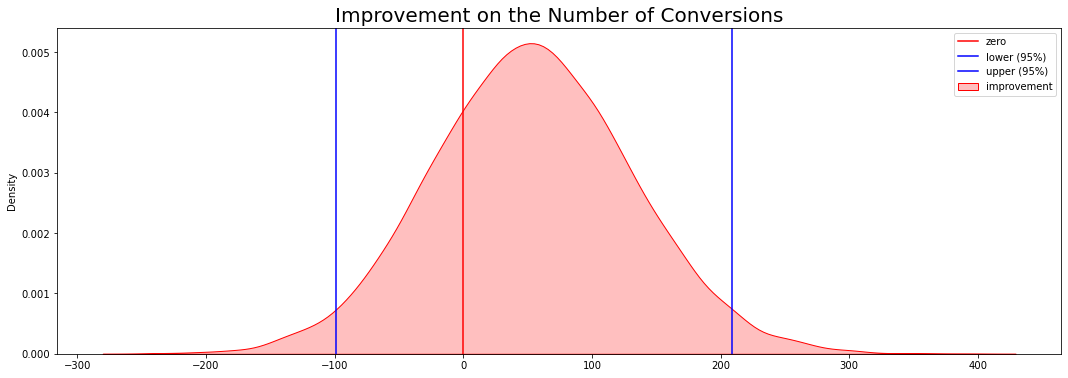

In [32]:
plt.figure(figsize=(18,6))

lower = np.percentile(cv_pred['B']-cv_pred['A'],2.5)
upper = np.percentile(cv_pred['B']-cv_pred['A'],97.5)

sns.kdeplot(cv_pred['B']-cv_pred['A'],color='red',shade='Fill',label='improvement')

plt.axvline(0,color='red',label='zero')
plt.axvline(lower,color='blue',label='lower (95%)')
plt.axvline(upper,color='blue',label='upper (95%)')

plt.legend()
plt.title('Improvement on the Number of Conversions',size=20)
plt.show()

# 가우시안 나이브 베이즈

In [33]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [34]:
customer = pd.read_csv('Customer.csv')
customer.head()

,cs_id,prd_cd,sex_cd,age,sal_amt,dc_amt,sal_freq
0,1,AB,F,25.0,82600.0,6260.0,4.0
1,2,AC,M,26.0,84400.0,11100.0,6.0
2,3,AB,F,28.0,103600.0,10660.0,5.0
3,4,AD,M,26.0,67200.0,9300.0,4.0
4,5,AC,F,22.0,65300.0,4230.0,3.0


In [35]:
customer['reg'] = (customer['sal_freq']>=10.0).astype('int')

In [36]:
th = customer['reg']
X  = customer[['sal_amt','dc_amt']]

In [37]:
X_train, X_test, th_train, th_test = train_test_split(X, th, test_size=0.3, random_state=1, stratify=th)

In [38]:
print('Labels counts in th:', np.bincount(th))
print('Labels counts in th_train:', np.bincount(th_train))
print('Labels counts in th_test:', np.bincount(th_test))

Labels counts in th: [672 328]
Labels counts in th_train: [470 230]
Labels counts in th_test: [202  98]


In [39]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std  = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
th_combined = np.hstack((th_train, th_test))

In [40]:
print(np.mean(X_train_std), np.std(X_train_std))

3.1086244689504386e-17 1.0


In [41]:
print(np.mean(X_test_std), np.std(X_test_std))

0.0618257914460383 0.9555089619192767


학습

In [42]:
gnb = GaussianNB()
gnb.fit(X_train_std, th_train)

GaussianNB()

In [43]:
th_pred = gnb.predict(X_test_std)
confusion_matrix(th_test, th_pred)

array([[182,  20],
       [ 16,  82]])

In [44]:
print('Misclassified samples: %d' % (th_test != th_pred).sum())

Misclassified samples: 36


In [45]:
print('Accuracy: %.2f' % accuracy_score(th_test, th_pred))

Accuracy: 0.88


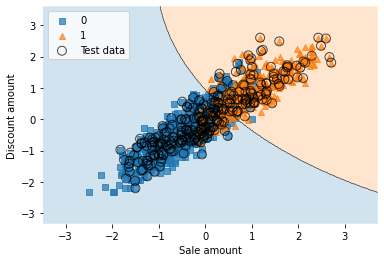

In [46]:
import matplotlib.pyplot as plt    
from IPython.display import Image
from mlxtend.plotting import plot_decision_regions

import warnings
warnings.filterwarnings(action='ignore')

scatter_kwargs = {'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}
scatter_highlight_kwargs = {'label': 'Test data', 'alpha': 0.7}

plot_decision_regions(X_combined_std, th_combined, clf=gnb, X_highlight=X_test_std,
                      scatter_kwargs=scatter_kwargs,
                      contourf_kwargs=contourf_kwargs,
                      scatter_highlight_kwargs=scatter_highlight_kwargs)
plt.xlabel('Sale amount')
plt.ylabel('Discount amount')
plt.legend(loc='upper left')
plt.savefig('GNB.png', dpi=300)
plt.show()

# 베르누이 나이브 베이즈

In [48]:
X = customer.drop('reg',axis=1)
X_bool = X.copy()
X_bool['sal_avg'] = X_bool['sal_amt']/X_bool['sal_freq'] 

In [49]:
def quantile_group(df,columns,q=4): # 사분위수로 나눔
    for col in columns:
        df['G_'+str(col)] = pd.qcut(df[col], q=q, labels=['q'+str(i) for i in range(1,q+1)]) 
        df.drop(col,axis=1,inplace=True)
    return df

In [50]:
def OH_encode(df,drop_first):
    df = quantile_group(df,['age','sal_avg','dc_amt']) # 연속형 변수들
    df = df[['prd_cd','sex_cd','G_age','G_sal_avg','G_dc_amt']]
    df = df.astype('object')
    df = pd.get_dummies(df, drop_first=drop_first)
    return df

In [51]:
X_bool = OH_encode(X_bool,drop_first=False)
X_bool.head()

,prd_cd_AA,prd_cd_AB,prd_cd_AC,prd_cd_AD,prd_cd_AE,sex_cd_F,sex_cd_M,G_age_q1,G_age_q2,G_age_q3,G_age_q4,G_sal_avg_q1,G_sal_avg_q2,G_sal_avg_q3,G_sal_avg_q4,G_dc_amt_q1,G_dc_amt_q2,G_dc_amt_q3,G_dc_amt_q4
0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0
1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
2,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0
3,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0


In [52]:
X_train, X_test, th_train, th_test = train_test_split(X_bool, th, test_size=0.3, random_state=1, stratify=th)

적합

In [53]:
bnb = BernoulliNB()
bnb.fit(X_train, th_train)

BernoulliNB()

In [54]:
th_pred = bnb.predict(X_test)
confusion_matrix(th_test, th_pred)

array([[178,  24],
       [ 15,  83]])

In [55]:
print('Misclassified samples: %d' % (th_test != th_pred).sum())

Misclassified samples: 39


In [56]:
print('Accuracy: %.2f' % accuracy_score(th_test, th_pred))

Accuracy: 0.87


# 범주형 나이브 베이즈

In [57]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import CategoricalNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [64]:
data = pd.read_table('Dermatology.data',sep=',',header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3


In [65]:
data.columns = ['col'+str(i) for i in data.columns]

In [66]:
data = data[data.col33!='?']

In [67]:
data['col33'] = pd.qcut(data['col33'].astype('int'),4,labels=[str(i) for i in range(0,4)])
data.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,3,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,1,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,2,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,2,3


In [68]:
X  = data.drop('col34',axis=1) # 피부질환을 나타내는 변수 제외하고 특성 변수로 정의
th = data['col34'] # 피부질환을 나타내는 변수를 범주 변수로 정의
th.value_counts()

1    111
3     71
2     60
5     48
4     48
6     20
Name: col34, dtype: int64

In [69]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(X)
X = enc.transform(X)

In [70]:
X_train, X_test, th_train, th_test = train_test_split(X, th, test_size=0.3, random_state=1, stratify=th)

학습

In [71]:
cnb = CategoricalNB()
cnb.fit(X_train, th_train)

CategoricalNB()

In [72]:
th_pred = cnb.predict(X_test)
confusion_matrix(th_test, th_pred)

array([[34,  0,  0,  0,  0,  0],
       [ 0, 17,  0,  1,  0,  0],
       [ 0,  0, 21,  0,  0,  0],
       [ 0,  0,  0, 14,  0,  0],
       [ 0,  0,  0,  0, 15,  0],
       [ 0,  0,  0,  0,  0,  6]])

In [73]:
print('Misclassified samples: %d' % (th_test != th_pred).sum())

Misclassified samples: 1


In [74]:
print('Accuracy: %.2f' % accuracy_score(th_test, th_pred))

Accuracy: 0.99


# 다항 나이브 베이즈

In [75]:
mnb = MultinomialNB()
mnb.fit(X_train, th_train)

MultinomialNB()

In [76]:
th_pred = mnb.predict(X_test)
confusion_matrix(th_test, th_pred)

array([[34,  0,  0,  0,  0,  0],
       [ 0, 18,  0,  0,  0,  0],
       [ 0,  0, 21,  0,  0,  0],
       [ 0,  1,  0, 13,  0,  0],
       [ 0,  0,  0,  0, 15,  0],
       [ 0,  0,  0,  0,  0,  6]])

In [77]:
print('Misclassified samples: %d' % (th_test != th_pred).sum())

Misclassified samples: 1


In [78]:
print('Accuracy: %.2f' % accuracy_score(th_test, th_pred))

Accuracy: 0.99


# 토픽 모델링

In [2]:
data = pd.read_table('Naver_shopping.txt',header=None)
data.columns=['star','review']

In [3]:
data = data[:20000]

In [4]:
doc1 = data[data.star==1].review.str.cat(sep='. ')
doc2 = data[data.star==2].review.str.cat(sep='. ')
doc3 = data[data.star==4].review.str.cat(sep='. ')
doc4 = data[data.star==5].review.str.cat(sep='. ')

In [5]:
data = pd.DataFrame([doc1,doc2,doc3,doc4],columns=['review'])
data['doc'] = data.index+1
data

,review,doc
0,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...,1
1,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고. 선물용으로 빨리 받아서 전달...,2
2,재구매 다 좋은데 하나가 이상하네요. 가성비 괜찮습니다 바퀴가 고정된다면 별다섯개짜...,3
3,배공빠르고 굿. 아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다....,4


In [6]:
data['review_filtered'] = data['review'].str.replace("[^ㄱ-ㅣ가-힣]", " ")
data

/Users/goyunjae/opt/miniconda3/envs/ML2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,review,doc,review_filtered
0,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...,1,주문을 월 에 시켰는데 월 일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...
1,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고. 선물용으로 빨리 받아서 전달...,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고 선물용으로 빨리 받아서 전달...
2,재구매 다 좋은데 하나가 이상하네요. 가성비 괜찮습니다 바퀴가 고정된다면 별다섯개짜...,3,재구매 다 좋은데 하나가 이상하네요 가성비 괜찮습니다 바퀴가 고정된다면 별다섯개짜...
3,배공빠르고 굿. 아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다....,4,배공빠르고 굿 아주좋아요 바지 정말 좋아서 개 더 구매했어요 이가격에 대박입니다 ...


In [7]:
#토큰화
doc_tokens = data['review_filtered'].apply(lambda x: x.split())

In [8]:
#3글자 이상만
doc_tokens = doc_tokens.apply(lambda x: ' '.join([w for w in x if len(w)>=3]))

In [9]:
#불용어 제거
stopwords = pd.read_csv('Korean_stopwords.txt',delimiter='\t',header=None)
stopwords = list(stopwords[0].values)

In [10]:
doc_tokens = doc_tokens.apply(lambda x: [item for item in x.split() if item not in stopwords])

In [11]:
#문서 합치기
docs = doc_tokens.apply(lambda x: ' '.join(x))

In [25]:
from konlpy.tag import Okt

AttributeError: module 'tweepy' has no attribute 'StreamListener'

In [26]:
!pip install tweepy

In [27]:
!pip install konlpy == 3.10.0

zsh:1: = not found


In [28]:
docs

0    주문을 시켰는데 배송이 왔네요 ㅎㅎㅎ 회사측과는 전화도 안되고 아무런 연락을 받을수...
1    택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고 선물용으로 받아서 전달했어야 ...
2    재구매 좋은데 하나가 이상하네요 가성비 괜찮습니다 바퀴가 고정된다면 별다섯개짜린데 ...
3    배공빠르고 아주좋아요 좋아서 구매했어요 이가격에 대박입니다 바느질이 엉성하긴 하지만...
Name: review_filtered, dtype: object

In [29]:
docs['tokens'] = docs.apply(lambda x: [w for w in Okt().nouns(x) if len(w)>=2]) 
docs['tokens'].head()

NameError: name 'Okt' is not defined

In [30]:
doc1 = docs['tokens'][0]
doc2 = docs['tokens'][1]
doc3 = docs['tokens'][2]
doc4 = docs['tokens'][3]
doc_list = [doc1,doc2,doc3,doc4]

KeyError: 'tokens'